In [1]:
import urllib.request, urllib.parse
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import string
import os

## Getting the data

I have included the data that i used for training the neural network, but i also wanted to include the functions which I have used to create the dataset. As I couldn't find a good free API with well-formatted data about the weather in Budapest I decided to read it from this [page's](http://idojarasbudapest.hu/archivalt-idojaras) HTML content. In order to make the page show the data a POST request must be sent.

In [2]:
#This function sends a POST request to the specified url in order to get the data. As mentioned above the data must be
# parsed from the html that is in the response
def get_one_month_data(yr, month):
    # the neccessary body params (ev is year, ho is month, button must be set to 'Mehet')
    data = {
        'ev': yr,
        'ho': month,
        'button': 'Mehet'
    }    
    data = bytes( urllib.parse.urlencode(data).encode())
    # send the request, read the response
    handler = urllib.request.urlopen( 'http://idojarasbudapest.hu/archivalt-idojaras', data )
    text = handler.read().decode('utf-8')
    #lets parse it using bs4 package
    soup = BeautifulSoup(text, 'html.parser')
    # the data is in a <table> HTML tag that we can find in the DOM
    table = soup.find_all('table')
    # not every year - month combination is valid (eg.: 2019-12) so we have to null check the table
    if (not table):
        return None
    # each day's data is in a <tr> tag, and we have to exclude the first row as it only contains the hungarian column headers
    rows = table[0].find_all('tr')[1:]
    to_return = []
    # add each row's useful data to the list as a string
    for row in rows:
        row_data = []
        for i, child in enumerate(row.findChildren()):
            if i < 5 and child.text is not '':
                row_data.append(child.text)
        to_return.append(row_data)
    return to_return

In [3]:
# This function iterates over each year month combination and concatenates the data for all of them
def read_all_data():
    unprocessed_data = []
    #These are the years that the page has data about, can be used to enumerate over them when retrieving the it
    years = ['2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019']
    #Used to enumerate over when getting the data
    months = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']
    # get the data for each month in the given timeframe
    for year in years:
        for month in months:
            temp = get_one_month_data(year, month)
            if (temp):
                # concat the new list with the existing one
                unprocessed_data += temp
    return unprocessed_data

In [4]:
#lets see what this does
read_all_data()

[['2011.09.29csütörtök', '26', '11', '0.8'],
 ['2011.09.30péntek', '25', '10', '1.4'],
 ['2011.10.01szombat', '25', '11', '1.7'],
 ['2011.10.02vasárnap', '27', '10', '2.8'],
 ['2011.10.03hétfő', '25', '9', '1.4'],
 ['2011.10.04kedd', '26', '11', '3.6'],
 ['2011.10.05szerda', '26', '11', '5.3'],
 ['2011.10.06csütörtök', '26', '11', '5.3'],
 ['2011.10.07péntek', '15', '6', '3.9'],
 ['2011.10.08szombat', '14', '5', '8.1'],
 ['2011.10.09vasárnap', '15', '3', '6.4'],
 ['2011.10.10hétfő', '16', '8', '3.9'],
 ['2011.10.11kedd', '22', '12', '6.4'],
 ['2011.10.12szerda', '19', '5', '7.2'],
 ['2011.10.13csütörtök', '16', '3', '5.8'],
 ['2011.10.14péntek', '13', '1', '2.2'],
 ['2011.10.15szombat', '14', '-1', '2.2'],
 ['2011.10.16vasárnap', '12', '-2', '2.2'],
 ['2011.10.17hétfő', '12', '-1', '0.8'],
 ['2011.10.18kedd', '13', '1', '2.2'],
 ['2011.10.19szerda', '18', '7', '4.4'],
 ['2011.10.20csütörtök', '11', '3', '3.9'],
 ['2011.10.21péntek', '13', '1', '1.7'],
 ['2011.10.22szombat', '13', '6', 

For each row the values are:
- Date (we don't need the name of the day)
- Max temperature
- Min temperature
- Wind speed


Average temperature can be calculated from min and max temterature. 

It looks like we have a time series on our hands. For this task a 1D convolutional network could have been used. However I decided to make a simple FC network and treat the date as a feature. I separated dates to year, month and day. Year could have been left out but after some testing it became obvious that it correlates with the average temperature.

I also decided not to use wind speed since it didn't help with the learning and I couldn't provide that feature for the dates specified (oct 30, nov 5, nov 26).

In [5]:
# This function creates the dataframe from the raw data
def create_data_frame():
    # I create a dictionary that can be used to create a pandas DataFrame
    data = {}
    # Add necessary keys with an empty list value
    data['year'] = []
    data['month'] = []
    data['day'] = []
    data['avg_temp'] = []
    #iterate over the data
    for record in read_all_data():
        # Date is splitted by year, month, day, only 0-10 chars are used as we don't care about the name of the days
        date = record[0][:10].split('.')
        year = int(date[0])
        month = int(date[1])
        day = int(date[2])
        data['year'].append(year)
        data['month'].append(month)
        data['day'].append(day)
        # calculate the average temparature from min and max
        data['avg_temp'].append(( float(record[1]) + float(record[2]) ) / 2)
    # create the DataFrame
    return pd.DataFrame(data)    

In [6]:
try:
    # if the file is already present then open it
    df = pd.read_csv('bp_temparature.csv')
except FileNotFoundError:
    # else create a new dataframe using the functions above
    df = create_data_frame()
    # and write it to a file so we don't have to create it next time
    df.to_csv('bp_temparature.csv', index=False)

In [7]:
#Lets have a look
df.head(10)

,year,month,day,avg_temp
0,2011,9,29,18.5
1,2011,9,30,17.5
2,2011,10,1,18.0
3,2011,10,2,18.5
4,2011,10,3,17.0
5,2011,10,4,18.5
6,2011,10,5,18.5
7,2011,10,6,18.5
8,2011,10,7,10.5
9,2011,10,8,9.5


We can separate the train and target variables, scale the data and start training

In [8]:
# import the necassary packages for training
from keras.models import Sequential
from sklearn.preprocessing import StandardScaler
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, Dropout, Activation
from keras.models import load_model
from keras.optimizers import SGD
from random import shuffle
np.random.seed(1000)

Using TensorFlow backend.
/home/daniel/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/daniel/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/daniel/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/daniel/.local/lib/python3.6/site-packages/tensorflow/python

In [9]:
dataset = df.values
# let's have 10% as test data and 20% as validation data
test_split = 0.1
valid_split = 0.2

# shuffle the dataset
shuffle(dataset)

#the last column (avg_temp) is the label
X = dataset[:,:3]
Y = dataset[:,3]

In [10]:
# Separating the data into test validation and train sets
v_index = int(X.shape[0]*(1-valid_split-test_split))
t_index = int(X.shape[0]*(1-test_split))

X_test = X[t_index:]
Y_test = Y[t_index:]
X_valid = X[v_index:t_index]
Y_valid = Y[v_index:t_index]
X = X[:v_index]
Y = Y[:v_index]

#scaling is based on the train data only
scaler = StandardScaler().fit(X)
X = scaler.transform(X)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

In [11]:
#define callbacks
patience=30
# using early stopping 
early_stopping=EarlyStopping(patience=patience, verbose=1)
checkpointer=ModelCheckpoint(filepath='weights.hdf5', save_best_only=True, verbose=1)
# two 30 neuron layers with sigmoid and a 1 neuron output layer with linear activation
# to target values in the (-10,30) range
model = Sequential()
model.add(Dense(output_dim=30, input_dim=X.shape[1]))
model.add(Activation('sigmoid'))
model.add(Dense(output_dim=30))
model.add(Activation('sigmoid'))
model.add(Dense(output_dim=1, activation='linear'))

#momentum can help us to get out of local minimums
sgd = SGD(lr=1e-2, decay=1e-5, momentum=0.9, nesterov=True)
# using mse for regression problem
model.compile(loss='mse', optimizer=sgd)
history=model.fit(X,Y,epochs=10000, 
                  batch_size=16,
                  verbose=2,
                  validation_data=(X_valid, Y_valid),
                  callbacks=[checkpointer, early_stopping])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(input_dim=3, units=30)`
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=30)`
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="linear", units=1)`
  del sys.path[0]



Train on 2060 samples, validate on 589 samples
Epoch 1/10000
 - 0s - loss: 66.8292 - val_loss: 27.2172

Epoch 00001: val_loss improved from inf to 27.21722, saving model to weights.hdf5
Epoch 2/10000
 - 0s - loss: 17.2537 - val_loss: 17.6944

Epoch 00002: val_loss improved from 27.21722 to 17.69443, saving model to weights.hdf5
Epoch 3/10000
 - 0s - loss: 15.1175 - val_loss: 15.7631

Epoch 00003: val_loss improved from 17.69443 to 15.76308, saving model to weights.hdf5
Epoch 4/10000
 - 0s - loss: 14.0197 - val_loss: 15.6837

Epoch 00004: val_loss improved from 15.76308 to 15.68368, saving model to weights.hdf5
Epoch 5/10000
 - 0s - loss: 13.7883 - val_loss: 16.2628

Epoch 00005: val_loss did not improve from 15.68368
Epoch 6/10000
 - 0s - loss: 13.2370 - val_loss: 15.3981

Epoch 00006: val_loss improved from 15.68368 to 15.39813, saving model to weights.hdf5
Epoch 7/10000
 - 0s - loss: 12.5741 - val_loss: 14.2307

Epoch 00007: val_loss improved from 15.39813 to 14.23066, saving model 

 - 0s - loss: 5.0565 - val_loss: 10.3477

Epoch 00067: val_loss did not improve from 9.99728
Epoch 68/10000
 - 0s - loss: 5.0215 - val_loss: 11.3620

Epoch 00068: val_loss did not improve from 9.99728
Epoch 69/10000
 - 0s - loss: 5.1905 - val_loss: 10.7220

Epoch 00069: val_loss did not improve from 9.99728
Epoch 70/10000
 - 0s - loss: 5.0524 - val_loss: 10.3573

Epoch 00070: val_loss did not improve from 9.99728
Epoch 71/10000
 - 0s - loss: 5.0658 - val_loss: 11.2950

Epoch 00071: val_loss did not improve from 9.99728
Epoch 72/10000
 - 0s - loss: 4.9546 - val_loss: 10.5360

Epoch 00072: val_loss did not improve from 9.99728
Epoch 73/10000
 - 0s - loss: 4.9189 - val_loss: 10.2927

Epoch 00073: val_loss did not improve from 9.99728
Epoch 74/10000
 - 0s - loss: 4.8245 - val_loss: 10.8389

Epoch 00074: val_loss did not improve from 9.99728
Epoch 75/10000
 - 0s - loss: 4.9390 - val_loss: 10.2768

Epoch 00075: val_loss did not improve from 9.99728
Epoch 76/10000
 - 0s - loss: 4.9288 - val_l

In [12]:
# load the weights that performed best on the validation dataset
from sklearn.metrics import mean_squared_error
model = load_model('weights.hdf5')
# predict for the test dataset
preds = model.predict(X_test)
test_err = mean_squared_error(Y_test,preds)
print("Test error: ",test_err)

Test error:  12.216420721424328


This means the network misses the target value by sqrt(12.216) = 3.5 C degrees on average.

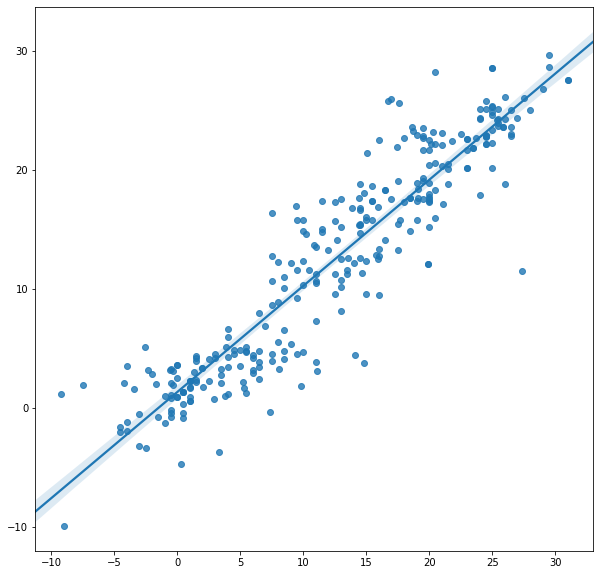

In [13]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
#lets visualize how the model performs
plt.figure(figsize=(10,10))
sns.regplot(x=Y_test, y=preds.reshape(-1), label='ddd')

Still some room for improvement, as it couln't really predict negative values well enough, but not a really bad result considering the fact that it only learned based on the date. 

In [14]:
# For our last task lets predict the average temperature for 2019. 10. 30., 2019. 11. 05. and 2019. 11. 26.
X_homework_test = np.array([[2019, 10, 30], [2019, 11, 5], [2019, 11, 26]])
X_homework_test = scaler.transform(X_homework_test)
homework_preds = model.predict(X_homework_test)
print('2019. 10. 30.: ', homework_preds[0][0], 'C')
print('2019. 11. 05.: ', homework_preds[1][0], 'C')
print('2019. 11. 26.: ', homework_preds[2][0], 'C')

2019. 10. 30.:  7.2554493 C
2019. 11. 05.:  3.08848 C
2019. 11. 26.:  4.662629 C
